# Classification Tasks Overview

This notebook implements two classification tasks:

1. **Student Pass/Fail Prediction** (synthetic dataset)
2. **Sentiment Analysis** on IMDB reviews


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 640.6 kB/s eta 0:00:00
  Using cached cloudpathlib-0.21.1-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.2.6 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.2.6 which is incompatible.
numba 0.59.0 requires numpy<1.27,>=1.22, but you have numpy 2.2.6 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.23.2; python_version == "3.11", but you have numpy 2.2.6 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.2.6 which is incompatible.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 326.8 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 944.1 kB/s eta 0:00:14
     - -------------------------------------- 0.4/12.8 MB 2.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 4.0 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 5.3 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 5.8 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 6.2 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 6.5 MB/s eta 0:00:02
     ----------- ---------------------------- 3.6/12.8 MB 6.9 MB/s eta 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import re
import spacy
nlp = spacy.load('en_core_web_sm')


## Task 1: Student Pass/Fail Prediction

### 1. Create Synthetic Dataset

In [2]:
# Generate synthetic student data
np.random.seed(42)
n = 200
study_hours = np.random.normal(30, 10, n).clip(0)
attendance = np.random.normal(75, 15, n).clip(0,100)
# Simulate pass probability
prob = 1 / (1 + np.exp(-0.1*(study_hours + 0.5*attendance - 50)))
pass_fail = (np.random.rand(n) < prob).astype(int)
df_students = pd.DataFrame({
    'StudyHours': study_hours,
    'Attendance': attendance,
    'Pass': pass_fail
})
df_students.head()

,StudyHours,Attendance,Pass
0,34.967142,80.366810,1
1,28.617357,83.411768,1
2,36.476885,91.245769,1
3,45.230299,90.807031,1
4,27.658466,54.334959,0


### 2. Data Exploration

StudyHours    0
Attendance    0
Pass          0
dtype: int64
       StudyHours  Attendance        Pass
count  200.000000  200.000000  200.000000
mean    29.592290   75.827399    0.795000
std      9.310039   13.767089    0.404715
min      3.802549   26.380990    0.000000
25%     22.948723   65.912437    1.000000
50%     29.958081   76.182590    1.000000
75%     35.008525   85.308467    1.000000
max     57.201692  100.000000    1.000000


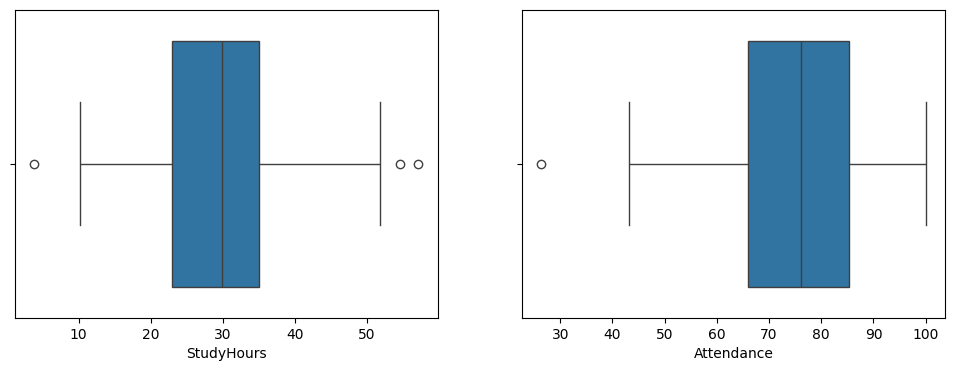

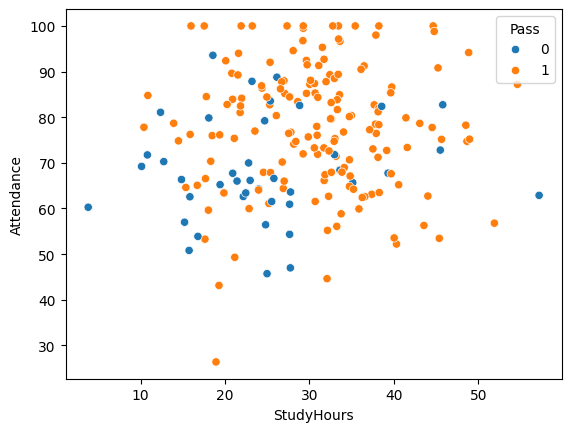

In [3]:
# Check for missing values and basic stats
print(df_students.isnull().sum())
print(df_students.describe())

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=df_students, x='StudyHours', ax=axes[0])
sns.boxplot(data=df_students, x='Attendance', ax=axes[1])
plt.show()

# Scatter plot colored by Pass
sns.scatterplot(data=df_students, x='StudyHours', y='Attendance', hue='Pass')
plt.show()

### 3. Model Training & Evaluation

Accuracy: 0.82


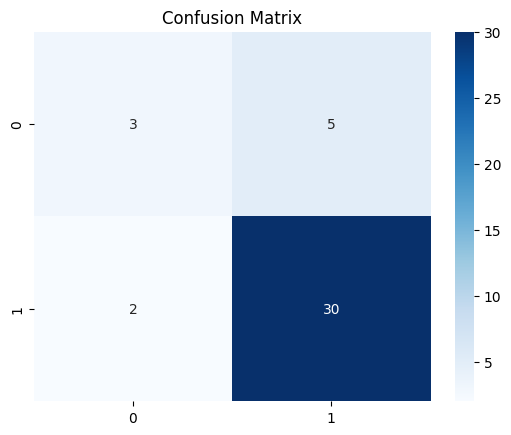

Coefficients: [[0.07456357 0.04752465]]


In [4]:
# Prepare data
X = df_students[['StudyHours','Attendance']]
y = df_students['Pass']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Train logistic regression
model1 = LogisticRegression()
model1.fit(X_train, y_train)
# Predict & evaluate
y_pred = model1.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {acc:.2f}')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
# Feature importance
print('Coefficients:', model1.coef_)

## Task 2: Sentiment Analysis on IMDB Dataset

Upload `IMDB Dataset.csv` when prompted.

In [3]:
import csv

# Manually read the CSV file line by line and handle errors
data = []
with open('/content/IMDB Dataset.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)  # Read the header row
    data.append(header)
    for i, row in enumerate(reader):
        try:
            # Attempt to process the row
            data.append(row)
        except Exception as e:
            print(f"Skipping row {i+2} due to error: {e}") # i+2 because of header and 0-based index

# Create a DataFrame from the valid data
df_imdb = pd.DataFrame(data[1:], columns=data[0])
display(df_imdb.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1. Preprocessing

In [4]:
def preprocess(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z ]', '', text).lower()
    doc = nlp(text)
    return ' '.join([tok.lemma_ for tok in doc if not tok.is_stop])

df_imdb['Clean'] = df_imdb['review'].apply(preprocess)
df_imdb[['Clean', 'sentiment']].head()

,Clean,sentiment
0,reviewer mention watch oz episode ll hook ri...,positive
1,wonderful little production filming technique ...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically s family little boy jake think s zom...,negative
4,petter matteis love time money visually stunni...,positive


### 2. Vectorization & Model Training

In [6]:
# TF-IDF
vect = TfidfVectorizer(max_features=5000)
X = vect.fit_transform(df_imdb['Clean'])

# Remove row with NaN in 'sentiment' before mapping and splitting
df_imdb_cleaned = df_imdb.dropna(subset=['sentiment']).copy()

y = df_imdb_cleaned['sentiment'].map({'positive':1, 'negative':0})
X_cleaned = vect.fit_transform(df_imdb_cleaned['Clean'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=0.2, stratify=y, random_state=1234
)

# Logistic regression
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### 3. Evaluation

Accuracy: 0.868421052631579
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1523
           1       0.85      0.89      0.87      1479

    accuracy                           0.87      3002
   macro avg       0.87      0.87      0.87      3002
weighted avg       0.87      0.87      0.87      3002



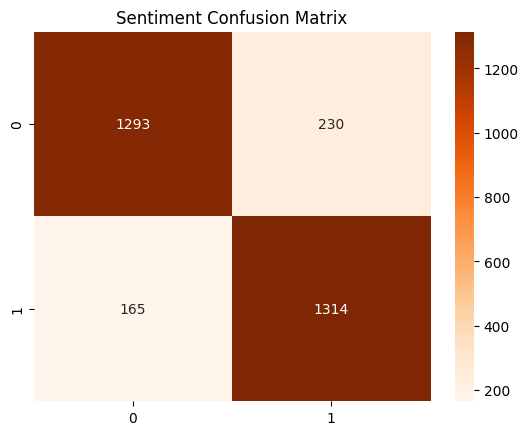

In [7]:
y_pred = model2.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges')
plt.title('Sentiment Confusion Matrix')
plt.show()